In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

In [2]:
load = pd.read_csv('salary.csv')

In [158]:
data = load.copy()


- Проведем первичный и визуальный анализ данных
    
- Удалим бесполезные признаки
    
- Сделаем предобработку данных


In [159]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [160]:
data.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'salary'],
      dtype='object')

In [161]:
data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [162]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  salary          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Посмотрим повнимательнее на колонки 'capital-gain' и 'capital-loss'

In [163]:
data['capital-gain'].where(data['capital-gain'] == 0, 'not zero').value_counts()

0           29849
not zero     2712
Name: capital-gain, dtype: int64

In [164]:
data['capital-loss'].where(data['capital-loss'] == 0, 'capital-loss').value_counts()

0               31042
capital-loss     1519
Name: capital-loss, dtype: int64

Теперь совместно на 'capital-gain' и 'capital-loss'. Оценим какое количество записей имеет одновременно информацию о 2х свойствах:

In [165]:
# Создадим временную колонку для подсчета ненулевых пар
data['comb'] = 0
data['comb'].where((data['capital-gain'] == 0)|(data['capital-loss'] == 0),
                           'not zero').value_counts(normalize =True).mul(100).round(2)

0    100.0
Name: comb, dtype: float64

Нет данных в которых одновременно была ненулевая информация о 'capital-gain' и 'capital-loss'
- Судя по описанию 'capital-gain' и 'capital-loss' это сумма зароботка и сумма затрат каждого клиента. Очевидно, что эти данные не полные и проще их исключить из анализа.

In [166]:
data = data.drop(columns=['comb', 'capital-gain', 'capital-loss'])

Далее обратим внимание на параметр 'fnlwgt':

Описание данной характеристики из первоисточника данных говорит о том, что это некий взвшененный показатель из 3 баз данных.
Другими словами, это уже взвешенный результат из нескольких моделей кластеризации социальных групп.

Испльзовать для кластеризации результаты другой кластеризации мы не будем, так как нам нужно получить интерпретируемые резальтаты а не оценку построенную на взвшененных оценках социальных характеристик.

Поэтому дропнем 'fnlwgt'

In [167]:
data = data.drop(columns=['fnlwgt'])

- age, education-num, hours-per-week

Можем использовать после нормализации (ранговые характеристики)

<h5> Далее обратим внимание на качественные признаки </h5>

In [168]:
data.select_dtypes('object').describe()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,salary
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


In [169]:
data.groupby('education')['education-num'].apply(lambda x: sorted(set(x))).sort_values()

education
 Preschool        [1]
 1st-4th          [2]
 5th-6th          [3]
 7th-8th          [4]
 9th              [5]
 10th             [6]
 11th             [7]
 12th             [8]
 HS-grad          [9]
 Some-college    [10]
 Assoc-voc       [11]
 Assoc-acdm      [12]
 Bachelors       [13]
 Masters         [14]
 Prof-school     [15]
 Doctorate       [16]
Name: education-num, dtype: object

Сравнили education c education-num: 
- убедились что education-num это ранговая интерпритация education (по возрастанию).

дропаем education

In [170]:
data = data.drop(columns=['education'])

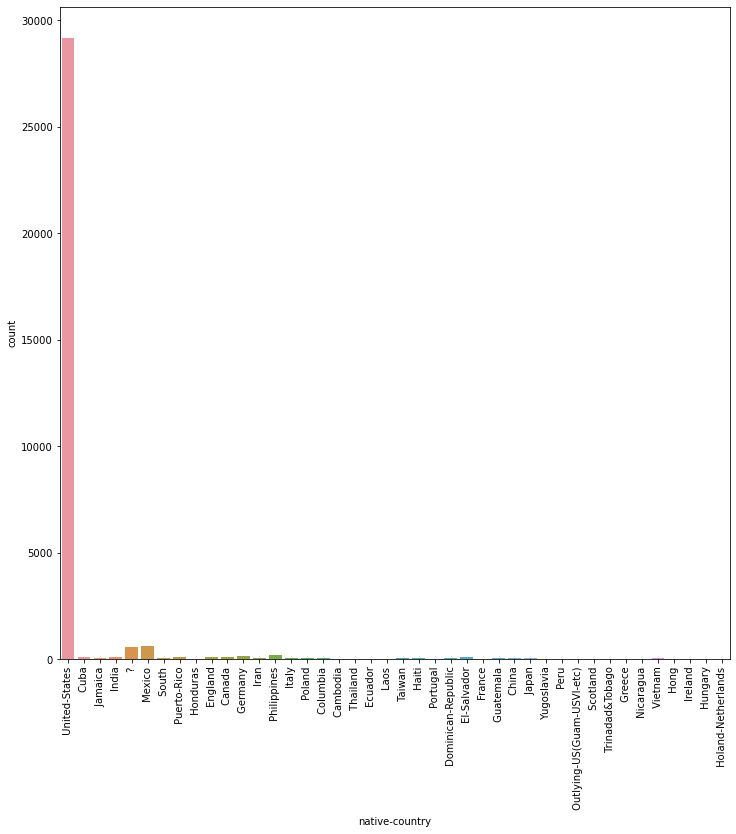

In [171]:
plt.figure(figsize=(12, 12))
sns.countplot(data=data, x='native-country')
plt.xticks(rotation=90)
plt.show()

In [172]:
data['native-country'].value_counts(normalize=True).mul(100).round(2)

 United-States                 89.59
 Mexico                         1.97
 ?                              1.79
 Philippines                    0.61
 Germany                        0.42
 Canada                         0.37
 Puerto-Rico                    0.35
 El-Salvador                    0.33
 India                          0.31
 Cuba                           0.29
 England                        0.28
 Jamaica                        0.25
 South                          0.25
 China                          0.23
 Italy                          0.22
 Dominican-Republic             0.21
 Vietnam                        0.21
 Guatemala                      0.20
 Japan                          0.19
 Poland                         0.18
 Columbia                       0.18
 Taiwan                         0.16
 Haiti                          0.14
 Iran                           0.13
 Portugal                       0.11
 Nicaragua                      0.10
 Peru                           0.10
 

In [173]:
data['native-country'].where( data['native-country'] == ' United-States', 'Other') \
.value_counts(normalize=True).mul(100).round(2)

 United-States    89.59
Other             10.41
Name: native-country, dtype: float64

Терять 10% полезной информации не хочется, поэтому просто сделаем из признака бинарный

<h5>Закодируем признак как 'IS_USA'. Соответственно как 1 - Yes, 0 - Other.</h5>
- Причем предварительно дропнем строки без данных (? - 1,79% данных)

In [174]:
# Дропаем пропуски
data[data['native-country'] == '?'] = np.nan
data = data.dropna()

In [175]:
# Кодируем новый признак на основе native-country
data['IS_USA'] = 1
data['IS_USA'] = data['IS_USA'].where(data['native-country'] == ' United-States', 0)

In [176]:
# Дропаем старый признак
data = data.drop(columns='native-country')

In [177]:
data.select_dtypes('object').describe()

,workclass,marital-status,occupation,relationship,race,sex,salary
count,32561,32561,32561,32561,32561,32561,32561
unique,9,7,15,6,5,2,2
top,Private,Married-civ-spouse,Prof-specialty,Husband,White,Male,<=50K
freq,22696,14976,4140,13193,27816,21790,24720


Признаки salary, sex - бинарные. Кодируем как 1/0

Из прошлых заданий копируем свои классы для Масштабирования и Кодирования признаков

In [178]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [179]:
# Encoder который не разбивает фрейм 
class MyEncoder():
    def __init__(self, columns=None):
        self.columns = columns
        self.dct = {}
    
    def __repr__(self):
        return f'MyEncoder метод LabelEncoder'
    
    def fit_transform(self, data):
        if not self.columns:
            for column in data.select_dtypes('object'):
                encoder = LabelEncoder()
                data[column] = encoder.fit_transform(data[column])
                self.dct[column] = {key: values for key, val in enumerate(encoder.classes_)}
        else:
            for column in self.columns:
                encoder = LabelEncoder()
                data[column] = encoder.fit_transform(data[column])
                self.dct[column] = {key: val for key, val in enumerate(encoder.classes_)}
        print('Выполнено')
        return data
    
# Scaler который не разбивает фрейм   
class MyScaler():
    def __init__(self, columns=None):
        self.columns = columns
    
    def __repr__(self):
        return f'MyScaler метод MinMax scale'

    def fit_transform(self, data_in):
        data = data_in
        if not self.columns:
            for column in data:
                scaler = MinMaxScaler()
                data[column] = scaler.fit_transform(data[column].values.reshape(-1, 1))
        else:
            for column in self.columns:
                scaler = MinMaxScaler()
                data[column] = scaler.fit_transform(data[column].values.reshape(-1, 1))
        print('Выполнено')
        return data

In [180]:
encode1 = MyEncoder(['salary', 'sex'])

In [181]:
data = encode1.fit_transform(data)

Выполнено


In [182]:
# Словарь кодирования признака
encode1.dct

{'salary': {0: ' <=50K', 1: ' >50K'}, 'sex': {0: ' Female', 1: ' Male'}}

In [183]:
data.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,salary,IS_USA
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,1,40.0,0,1
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,1,13.0,0,1
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,1,40.0,0,1
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,1,40.0,0,1
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,0,40.0,0,0


<h5>Посмотрим на остальные категориальные данные</h5>

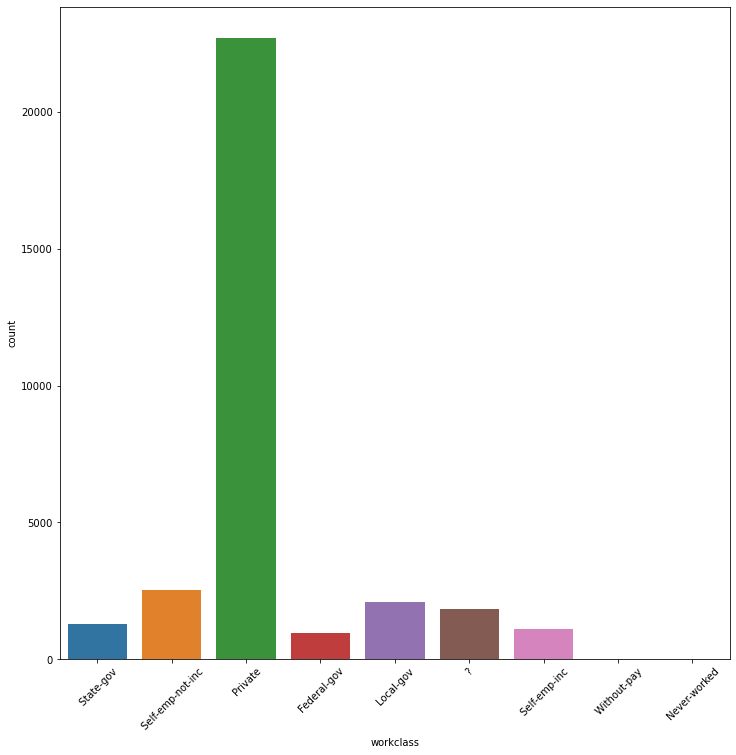

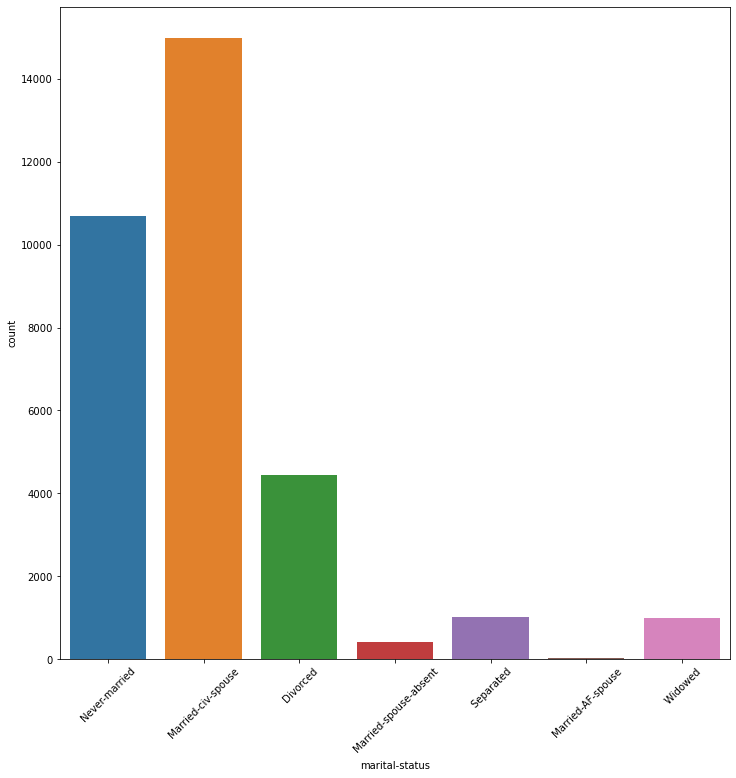

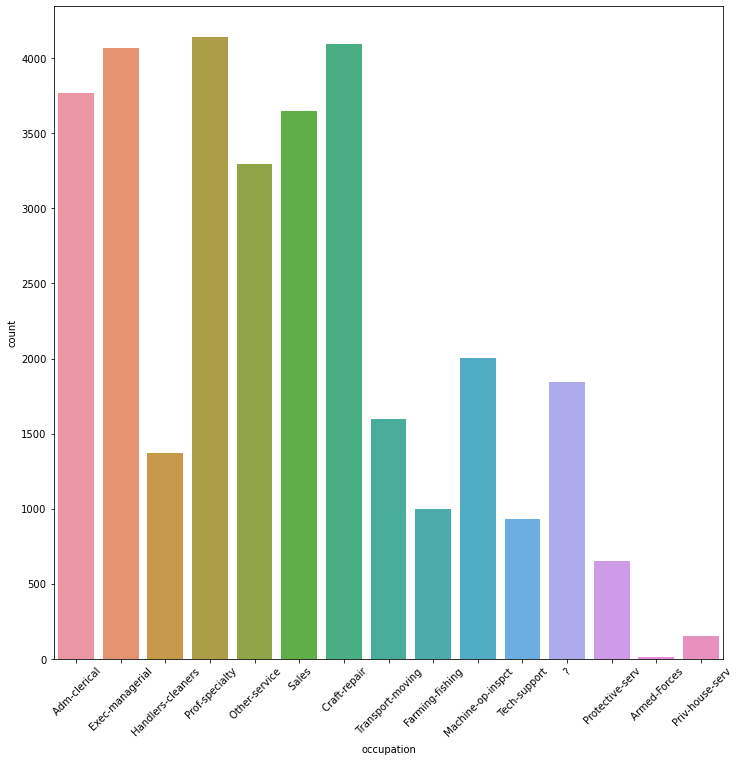

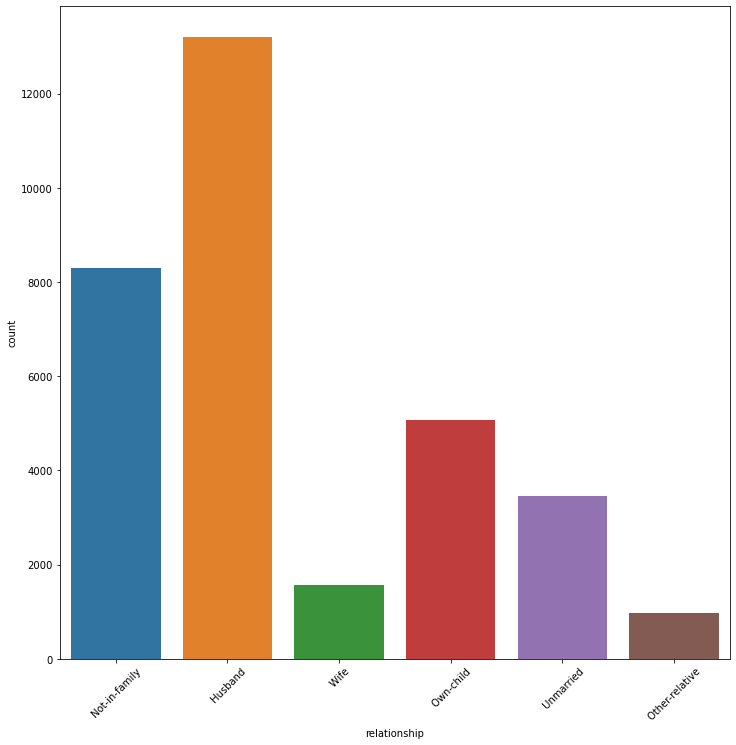

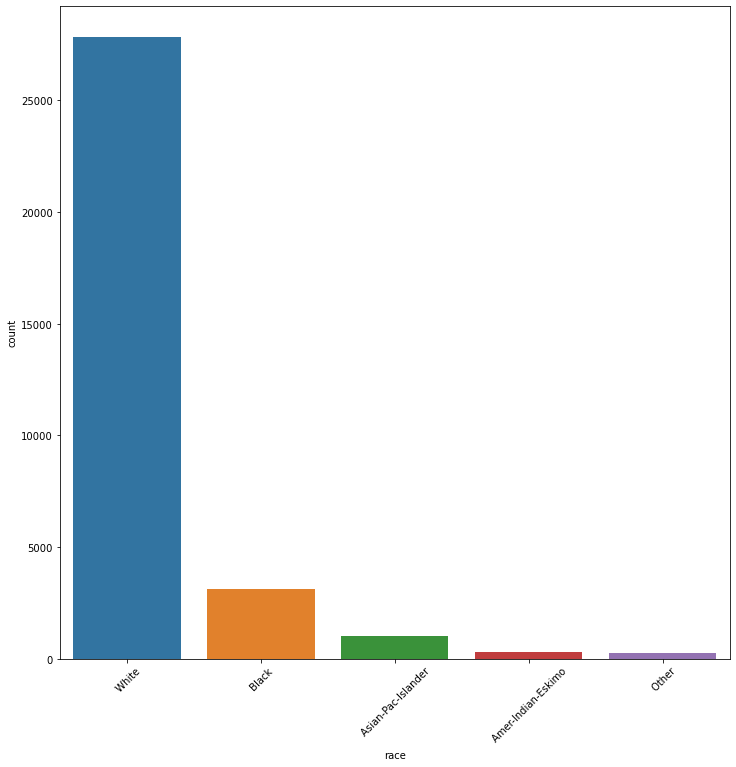

In [184]:
for el in data.select_dtypes('object'):
    plt.figure(figsize=(12, 12))
    sns.countplot(data=data, x=el)
    plt.xticks(rotation=45)
    plt.show()

 - Категории race, relationship, workclass, marital-status, occupation кодируем CountEncoder
 - occupation неизвестные данные дропнем 

In [185]:
data = data.drop(index = data[data['occupation'] == ' ?'].index)

In [186]:
# Класс для CountEncoder
class MyCountEncoder():
    def __init__(self, columns=None):
        # Сюда забрасываем колонки которые хотим обработать
        self.columns = columns
        # Это словарь произведенных замен, для обратной интерпритации
        self.dct = {}
    
    def __repr__(self):
        return f'MyCountEncoder метод CountEncoder'
    
    def fit_transform(self, data):
        data = data.copy()
        if not self.columns:
            # Если не подали список колонок, будем кодировать все
            for column in data.select_dtypes('object'):
                # Тут создали словарь замен
                self.dct[column] = data[column].value_counts().reset_index().to_dict()['index']
                
                # Тут перевернули словарь для прямой замены
                dct_for_transform = {k: v for v, k in self.dct[column].items()}
                
                # Тут применили его к колонке
                data[column] = data[column].map(dct_for_transform)
        else:
            for column in self.columns:
                # Тут создали словарь замен
                self.dct[column] = data[column].value_counts().reset_index().to_dict()['index']
                
                # Тут перевернули словарь для прямой замены
                dct_for_transform = {k: v for v, k in self.dct[column].items()}
                
                # Тут применили его к колонке
                data[column] = data[column].map(dct_for_transform)
        print('Выполнено')
        return data
        

In [187]:
encoder2 = MyCountEncoder(['race', 'relationship', 'workclass', 'marital-status', 'occupation'])

In [188]:
data = encoder2.fit_transform(data)

Выполнено


In [189]:
# Словарь кодирования признаков
encoder2.dct

{'race': {0: ' White',
  1: ' Black',
  2: ' Asian-Pac-Islander',
  3: ' Amer-Indian-Eskimo',
  4: ' Other'},
 'relationship': {0: ' Husband',
  1: ' Not-in-family',
  2: ' Own-child',
  3: ' Unmarried',
  4: ' Wife',
  5: ' Other-relative'},
 'workclass': {0: ' Private',
  1: ' Self-emp-not-inc',
  2: ' Local-gov',
  3: ' State-gov',
  4: ' Self-emp-inc',
  5: ' Federal-gov',
  6: ' Without-pay'},
 'marital-status': {0: ' Married-civ-spouse',
  1: ' Never-married',
  2: ' Divorced',
  3: ' Separated',
  4: ' Widowed',
  5: ' Married-spouse-absent',
  6: ' Married-AF-spouse'},
 'occupation': {0: ' Prof-specialty',
  1: ' Craft-repair',
  2: ' Exec-managerial',
  3: ' Adm-clerical',
  4: ' Sales',
  5: ' Other-service',
  6: ' Machine-op-inspct',
  7: ' Transport-moving',
  8: ' Handlers-cleaners',
  9: ' Farming-fishing',
  10: ' Tech-support',
  11: ' Protective-serv',
  12: ' Priv-house-serv',
  13: ' Armed-Forces'}}

In [190]:
data.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,salary,IS_USA
0,39.0,3,13.0,1,3,1,0,1,40.0,0,1
1,50.0,1,13.0,0,2,0,0,1,13.0,0,1
2,38.0,0,9.0,2,8,1,0,1,40.0,0,1
3,53.0,0,7.0,0,8,0,1,1,40.0,0,1
4,28.0,0,13.0,0,0,4,1,0,40.0,0,0


Теперь посмотрим на обработанные данные, после чего масштабируем все признаки

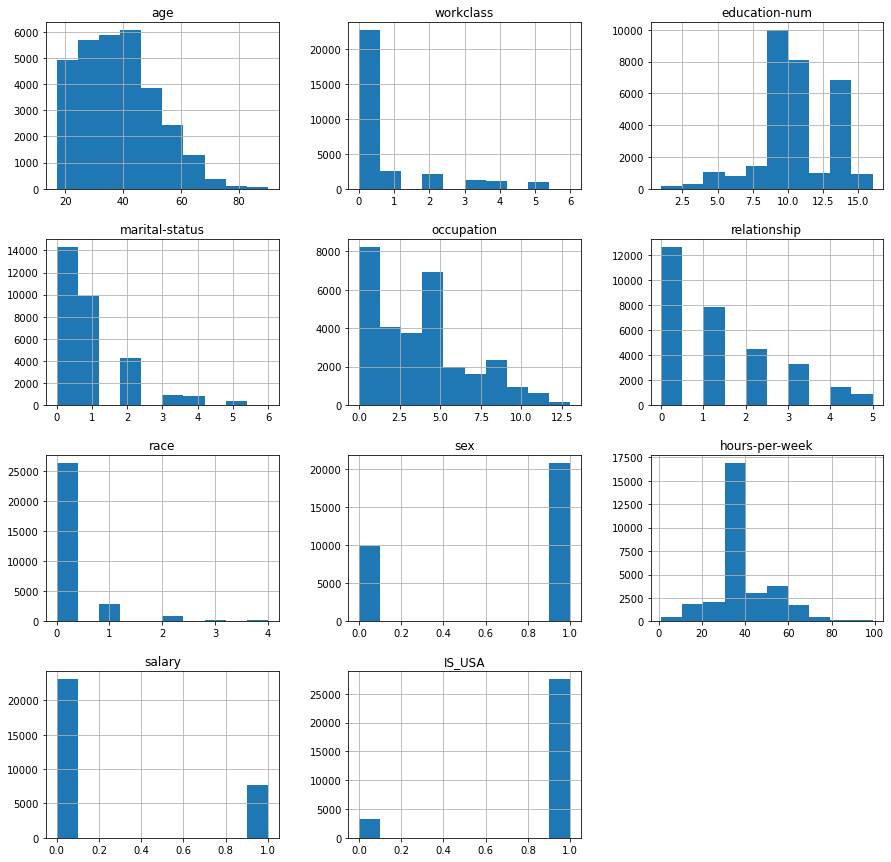

In [194]:
data.hist(figsize=(15, 15))
plt.show()

In [197]:
scaler = MyScaler()
data = scaler.fit_transform(data)

Выполнено


In [198]:
data.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,salary,IS_USA
0,0.301370,0.500000,0.800000,0.166667,0.230769,0.2,0.00,1.0,0.397959,0.0,1.0
1,0.452055,0.166667,0.800000,0.000000,0.153846,0.0,0.00,1.0,0.122449,0.0,1.0
2,0.287671,0.000000,0.533333,0.333333,0.615385,0.2,0.00,1.0,0.397959,0.0,1.0
3,0.493151,0.000000,0.400000,0.000000,0.615385,0.0,0.25,1.0,0.397959,0.0,1.0
4,0.150685,0.000000,0.800000,0.000000,0.000000,0.8,0.25,0.0,0.397959,0.0,0.0


- Обучите модель понижения размерности для визуализации данных в 2D пространстве

Обучим модель TSNE понижения размерности (спойлер, пришлось накручивать преплексити до 300)

In [250]:
%%time
dim_reducer = TSNE(n_components=2, random_state=42, perplexity=300)
components = dim_reducer.fit_transform(data)

C:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CPU times: total: 40min 48s
Wall time: 13min 45s


In [251]:
colnames = ['component_' + str(i) for i in range(1, 3)]
components_df = pd.DataFrame(data = components, columns = colnames)

In [252]:
components_df

,component_1,component_2
0,16.918196,18.005461
1,6.223181,31.592295
2,5.176015,7.507951
3,-4.643908,26.184011
4,41.352005,0.903405
...,...,...
30713,-47.707680,-6.436684
30714,20.946011,-42.803722
30715,-39.055954,5.756112
30716,1.580952,-12.505891


In [386]:
# Функцию визуализатор честно тиснул из урока, потому что так быстрее
def display_components_in_2D_space(components_df, labels=None):
    frame_labels = pd.DataFrame(labels)
    components_with_labels_df = pd.concat([components_df, frame_labels], axis=1)

    figsize = (10, 7)
    if labels is not None:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', 
                                         c=components_with_labels_df.iloc[:, -1], cmap=plt.get_cmap('jet'),
                                         alpha=0.5, figsize=figsize)
    else:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', alpha=0.5, figsize=figsize)

    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects')    
    plt.show()

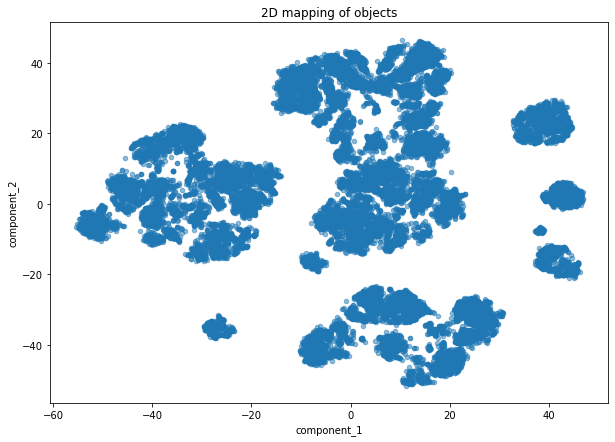

In [315]:
display_components_in_2D_space(components_df)

Модель 1: KMeans

In [274]:
from sklearn.cluster import KMeans

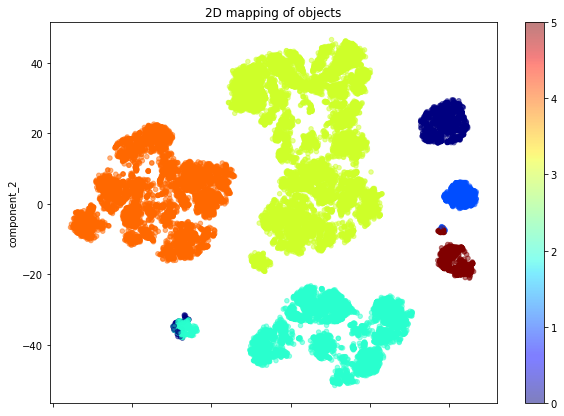

In [370]:
kmeans = KMeans(n_clusters=6, random_state=30)
labels_clast_km = kmeans.fit_predict(data)

unique, counts = np.unique(pd.Series(labels_clast_km), return_counts=True)
display_components_in_2D_space(components_df, labels_clast_km)

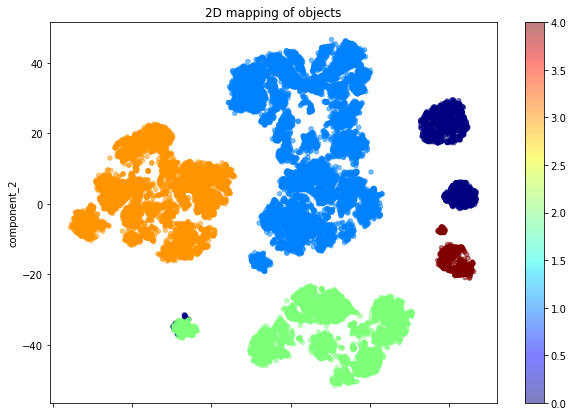

In [378]:
kmeans = KMeans(n_clusters=5, random_state=30)
labels_clast_km = kmeans.fit_predict(data)

unique, counts = np.unique(pd.Series(labels_clast_km), return_counts=True)
display_components_in_2D_space(components_df, labels_clast_km)

In [379]:
labels_clast_km_final = labels_clast_km

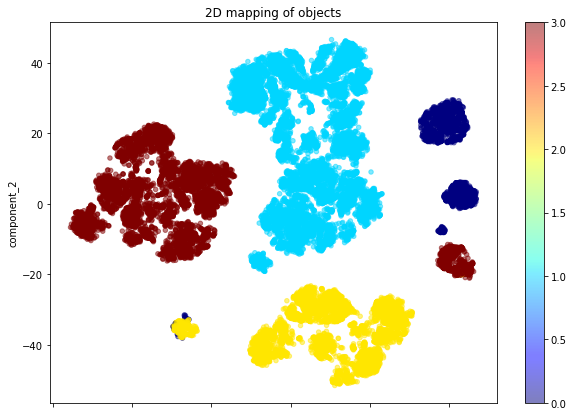

In [326]:
kmeans = KMeans(n_clusters=4, random_state=30)
labels_clast_km = kmeans.fit_predict(data)

unique, counts = np.unique(pd.Series(labels_clast_km), return_counts=True)
display_components_in_2D_space(components_df, labels_clast_km)

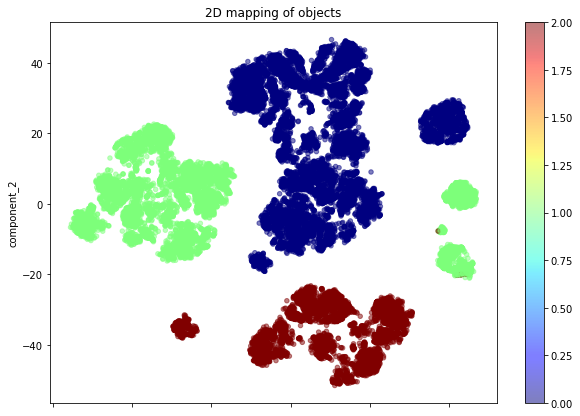

In [328]:
kmeans = KMeans(n_clusters=3, random_state=30)
labels_clast_km = kmeans.fit_predict(data)

unique, counts = np.unique(pd.Series(labels_clast_km), return_counts=True)
display_components_in_2D_space(components_df, labels_clast_km)

При 3 кластерах разделение почище, но есть вопросы к салатовой группе
Выберем количество кластеров 3

Модель 2: Будет иерархическая

In [307]:
from sklearn.cluster import AgglomerativeClustering

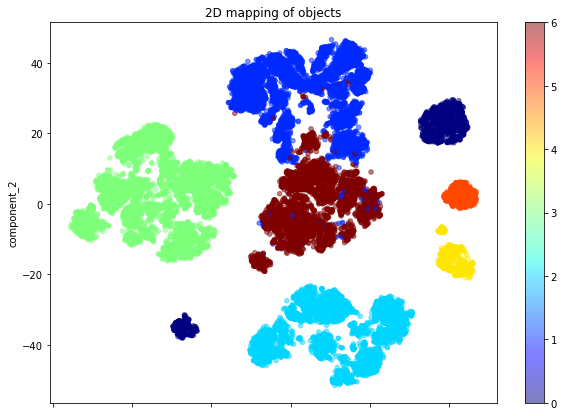

CPU times: total: 1min 8s
Wall time: 1min 9s


In [374]:
%%time
aggl = AgglomerativeClustering(n_clusters=7)
labels_clast_ag = aggl.fit_predict(data)
display_components_in_2D_space(components_df, labels_clast_ag)

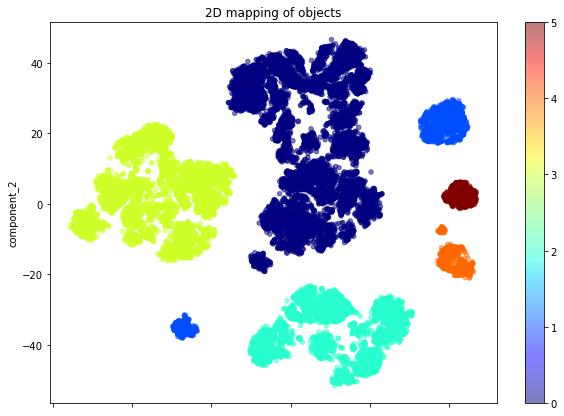

CPU times: total: 1min 11s
Wall time: 1min 12s


In [375]:
%%time
aggl = AgglomerativeClustering(n_clusters=6)
labels_clast_ag = aggl.fit_predict(data)
display_components_in_2D_space(components_df, labels_clast_ag)

In [376]:
labels_clast_ag_final = labels_clast_ag

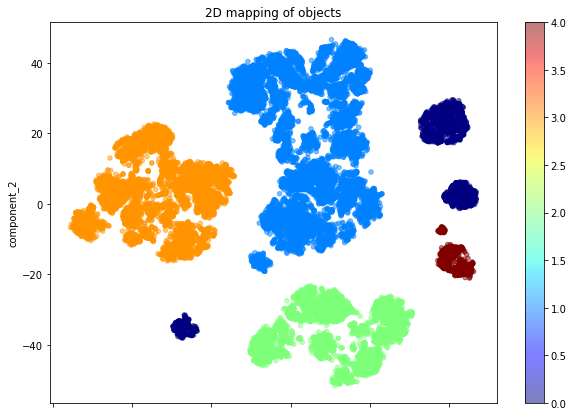

CPU times: total: 1min 13s
Wall time: 1min 14s


In [373]:
%%time
aggl = AgglomerativeClustering(n_clusters=5)
labels_clast_ag = aggl.fit_predict(data)
display_components_in_2D_space(components_df, labels_clast_ag)

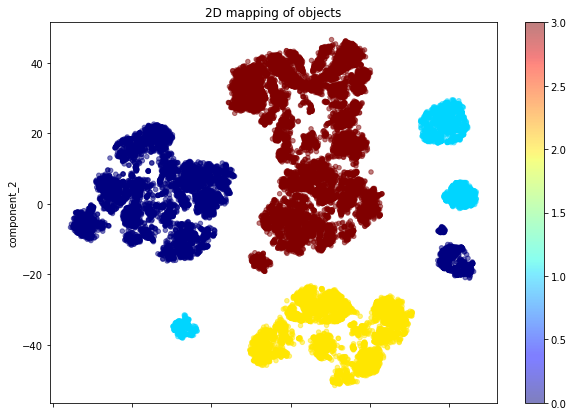

CPU times: total: 1min 18s
Wall time: 1min 24s


In [332]:
%%time
aggl = AgglomerativeClustering(n_clusters=4)
labels_clast_ag = aggl.fit_predict(data)
display_components_in_2D_space(components_df, labels_clast_ag)

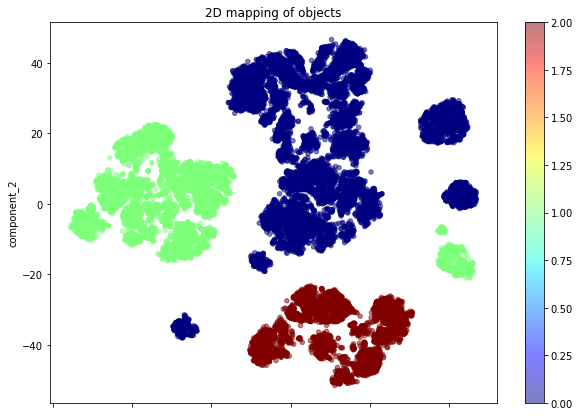

CPU times: total: 1min 8s
Wall time: 1min 9s


In [365]:
%%time
aggl = AgglomerativeClustering(n_clusters=3)
labels_clast_ag = aggl.fit_predict(data)
display_components_in_2D_space(components_df, labels_clast_ag)

Модель 3: DBSCAN (возьму 3 потому что первые 2 не дали нормальных результатов)

In [336]:
from sklearn.cluster import DBSCAN

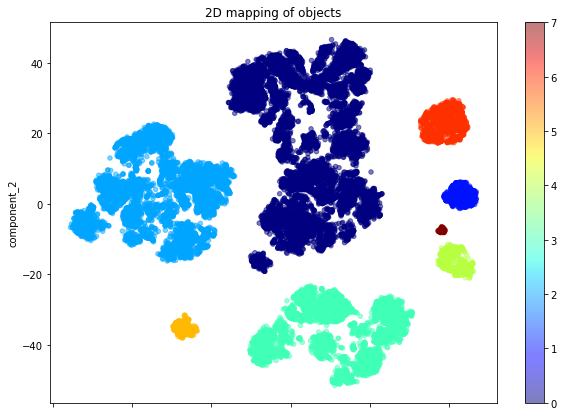

In [355]:
dbscan = DBSCAN(eps=0.995, min_samples=2)
labels_clast_db = dbscan.fit_predict(data)
display_components_in_2D_space(components_df, labels_clast_db)

In [377]:
labels_clast_db_final = labels_clast_db

Рассмотрим лучшие варианты разделения:
1. DBSCAN Предложил разделение на 8 кластеров
2. КMeans лучшее разделение на 5 кластеров
3. Иерархический алгоритм лучшее разделение на 6 кластеров

Чтобы выбрать модель кластеризации построим боксплот для каждого варианта.
Нам важна интерпретируемость разделения по группам, выберем ту модель где проще интерпретировать результаты.

In [380]:
data_final = data.copy()
data_final['Group_AG'] = labels_clast_ag_final
data_final['Group_DB'] = labels_clast_db_final
data_final['Group_KM'] = labels_clast_km_final

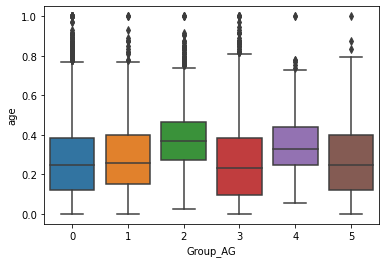

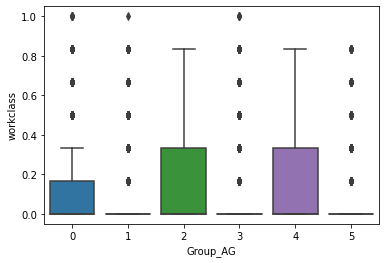

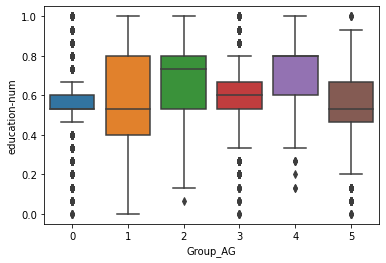

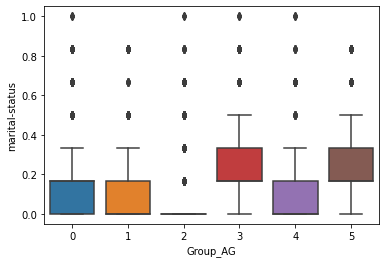

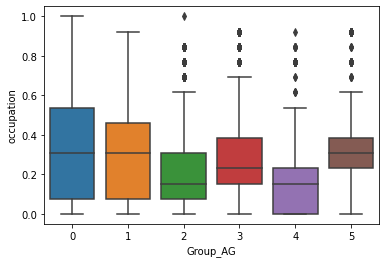

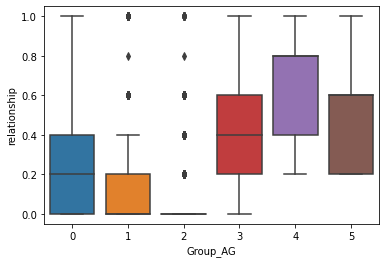

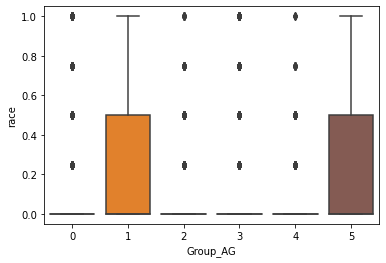

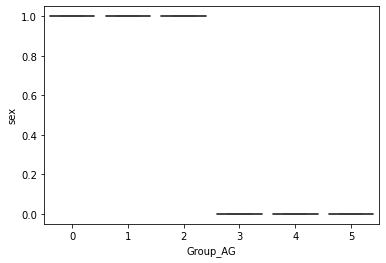

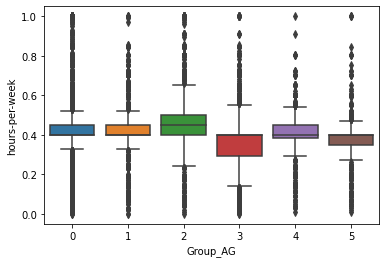

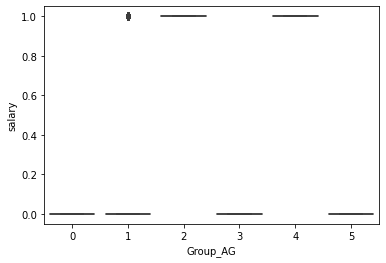

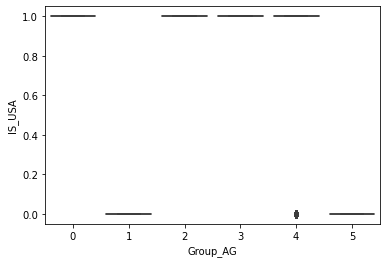

In [381]:
for column in data:
    sns.boxplot(x=data_final["Group_AG"], y=data_final[column])
    plt.show()

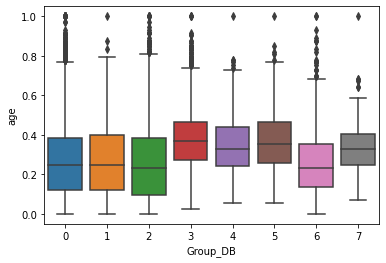

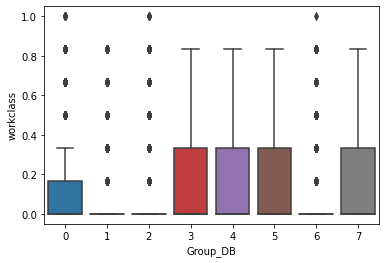

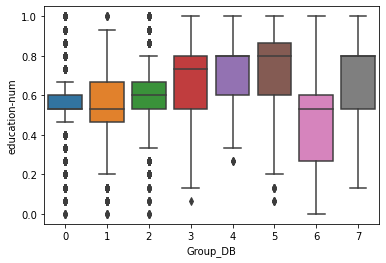

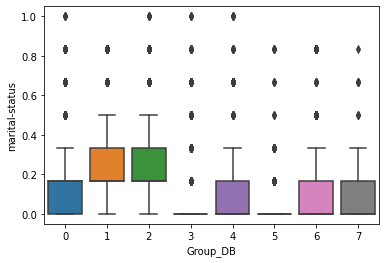

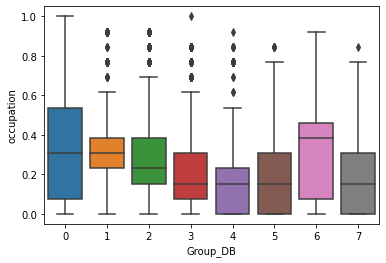

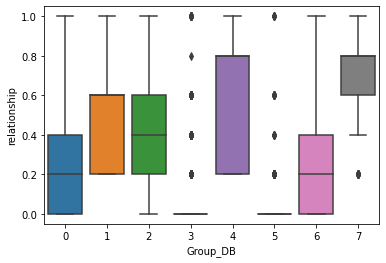

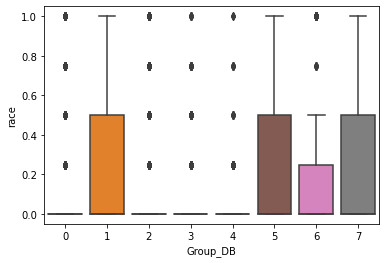

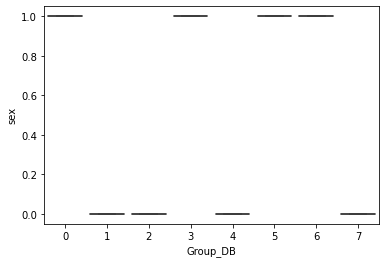

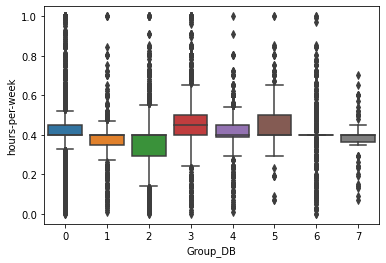

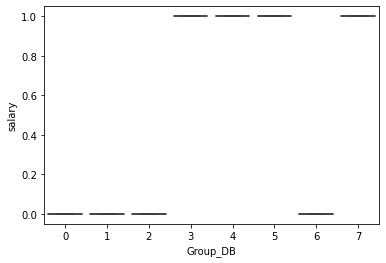

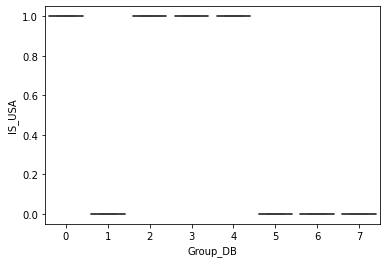

In [383]:
for column in data:
    sns.boxplot(x=data_final["Group_DB"], y=data_final[column])
    plt.show()

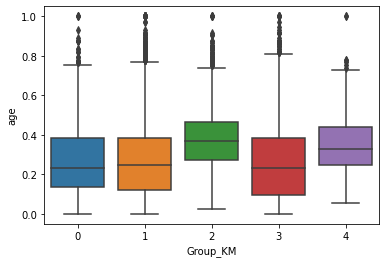

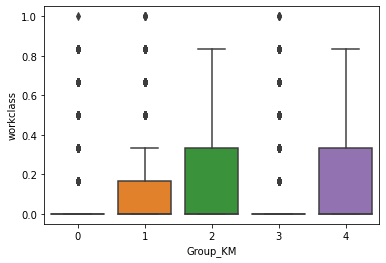

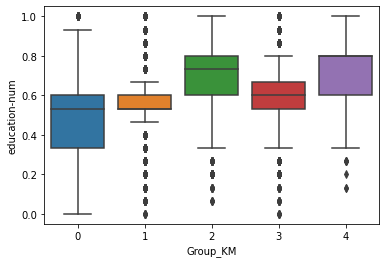

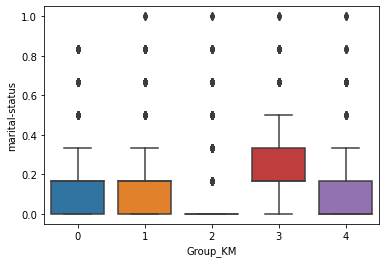

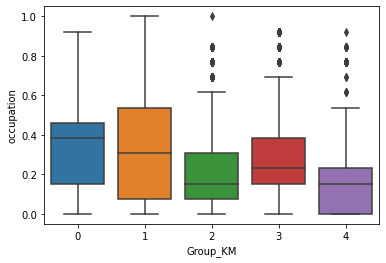

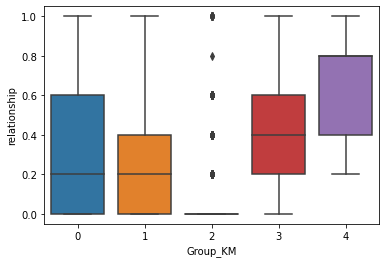

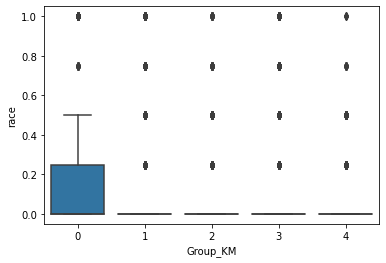

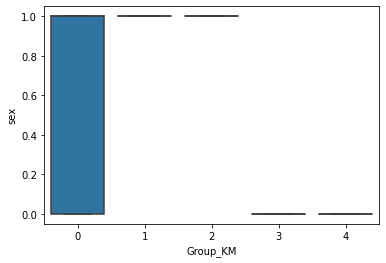

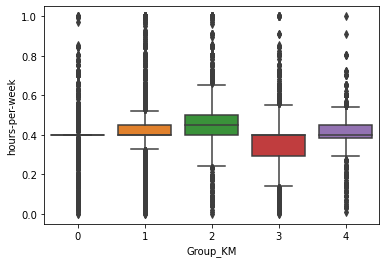

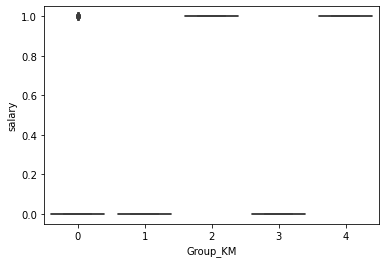

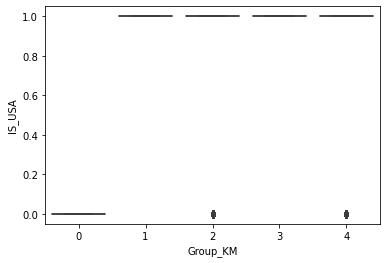

In [382]:
for column in data:
    sns.boxplot(x=data_final["Group_KM"], y=data_final[column])
    plt.show()

Для интерпритации скопируем словарь замен, который использовали при кодировании

In [384]:
ф ={'race': {0: ' White',
  1: ' Black',
  2: ' Asian-Pac-Islander',
  3: ' Amer-Indian-Eskimo',
  4: ' Other'},
 'relationship': {0: ' Husband',
  1: ' Not-in-family',
  2: ' Own-child',
  3: ' Unmarried',
  4: ' Wife',
  5: ' Other-relative'},
 'workclass': {0: ' Private',
  1: ' Self-emp-not-inc',
  2: ' Local-gov',
  3: ' State-gov',
  4: ' Self-emp-inc',
  5: ' Federal-gov',
  6: ' Without-pay'},
 'marital-status': {0: ' Married-civ-spouse',
  1: ' Never-married',
  2: ' Divorced',
  3: ' Separated',
  4: ' Widowed',
  5: ' Married-spouse-absent',
  6: ' Married-AF-spouse'},
 'occupation': {0: ' Prof-specialty',
  1: ' Craft-repair',
  2: ' Exec-managerial',
  3: ' Adm-clerical',
  4: ' Sales',
  5: ' Other-service',
  6: ' Machine-op-inspct',
  7: ' Transport-moving',
  8: ' Handlers-cleaners',
  9: ' Farming-fishing',
  10: ' Tech-support',
  11: ' Protective-serv',
  12: ' Priv-house-serv',
  13: ' Armed-Forces'}}

Разделение на 5 кластеров (Модель KMeans) проще интерпретировать по сигнатурным признакам
Таким образом можем составить портрет клиентов:
    
Группа 0:
- Не американец
- Низкая ЗП
- Нестабильный график работы (возможно временная) (робочие часы в месяц имеют хаотичный разброс)
- Пол любой
- Расса любая (но среди этой группы самый большой процент не белых)
- Образование любое

Группа 1:
- Американец
- Низкая ЗП
- График любой
- Мужчина
- в основном белый
- Средний грейд образования

Группа 2:
- В основном Американец (иногда нет)
- Высокая ЗП
- Стабильный график работы, около 40 раб часов в среднем
- Мужчина
- в основном белый
- Высокий грейд образования

Группа 3:
- Американец
- Низкая ЗП
- Стабильный график работы, в основном ниже 35 раб часов
- Женщина
- В основном белая
- Без супруга
- Часто с ребенком
- Средний грейд образования

Группа 4:
- В основном Американец (иногда нет)
- Высокая ЗП
- Стабильный график работы, около 40 раб часов в среднем
- Женщина
- В основном белая
- Семейное положение - по разному
- Высокий грейд образования

Еще по группам можно дополнительно находить штрихи:
Например группа 0: 
иностранцы с низким доходом и нестабильной работой почти всегда работают частный работник
Группа 2 и 4 (с самыми высокими доходами):
Часто работают в госсекторе, имеют собственную компанию, либо в найме

Выводы по работе:
- Провел предобработку данных
- Провел уменьшение размерности
- Обучил 3 вида моделей кластеризации
- Выбрал модель с меньшим количеством кластеров и более понятной интерпритацией
- Расписал пример интерпритации классов

PS Модель DBSCAN с 8 кластерами тоже интересно поизучать, 
по этой классификации можно выделить более тонкие паттерны. Я выбрал KMeans потому что не смотря, на более грубое разделение
оно основано на признаках, которые проще собрать (пол, раса, гражданство, образование).
